In [117]:
from transformers import AutoTokenizer,AutoModelForTokenClassification
import torch
import re
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [118]:
df = pd.read_excel("data testing.xlsx")
df

,berita,sentiment
0,pos indonesia menyebut pendistribusian bst dit...,0
1,kejaksaan tinggi jawa barat menahan empat ters...,0
2,wjtoday bandung kejaksaan tinggi kejati jawa b...,0
3,wartakotaliv pusat perbelanjaan kini antara pt...,0
4,gara gara mengubah fungsi bangunan plaza pusat...,0
...,...,...
80,semarang – wakil gubernur jawa tengah taj yasi...,1
81,liputan com rembang gerakan pemuda gp ansor re...,1
82,weekend ini bingung mau nongkrong di mana temp...,1
83,perajin usaha mikro kecil dan menengah umkm bu...,1


In [119]:
df['berita'] = df['berita'].replace({'"':' ',
                                 '\d+':' ',
                                 ':':' ',
                                 ';':' ',
                                 '#':' ',
                                 '_':' ',
                                 ',':' ',
                                 "'":' ',
                                  }, regex=True)

df['berita'] = df['berita'].str.replace(r'[https]+[?://]+[^\s<>"]+|www\.[^\s<>"]+[?()]+[(??)]+[)*]+[(\xa0]+[-&gt]', " ",regex=True)

df['berita'] = df['berita'].replace('\n','.', regex=True)

df['berita'] = df['berita'].replace({'\.':' ','(/)':'','\(':'','\)':''},regex=True)
df['berita'] = df['berita'].replace('[\.:"]',' ',regex =True)
df['berita'] = df['berita'].replace('\?', ' ', regex=True)
df['berita'] = df['berita'].replace('\!', ' ', regex=True)
df['berita'] = df['berita'].replace('\*', ' ', regex=True)
df['berita'] = df['berita'].replace('\%', ' ', regex=True)
df['berita'] = df['berita'].replace('\&', ' ', regex=True)
df['berita'] = df['berita'].replace('\~', ' ', regex=True)
df['berita'] = df['berita'].replace('\=', ' ', regex=True)
df['berita'] = df['berita'].replace('\-', ' ', regex=True)
df['berita'] = df['berita'].replace('@', ' ', regex=True)
df['berita'] = df['berita'].str.replace(r'[^\w\s]+', '')
#df['berita'].astype(str)
df['berita'] = df['berita'].replace('\s+', ' ', regex=True)
df['berita'] = df['berita'].str.strip()
df['berita'] = df['berita'].str.lower()

C:\Users\PC\AppData\Local\Temp/ipykernel_20056/327192537.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df['berita'] = df['berita'].str.replace(r'[^\w\s]+', '')


In [120]:
df_neg = df[df['sentiment'] == 0]
df_pos = df[df['sentiment'] == 1]
print(f"negatif shape {df_neg.shape}")
print(f"postif shape {df_pos.shape}")
print(f"total shape {df.shape}")

negatif shape (32, 2)
postif shape (53, 2)
total shape (85, 2)


In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['berita'], df['sentiment'], test_size=0.33, random_state=42)

In [122]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [123]:
def get_sentence_embeding(sentences):
    preprocessed_berita = bert_preprocess(sentences)
    return bert_encoder(preprocessed_berita)['pooled_output']

get_sentence_embeding([
    "saya membenci pos indonesia",
    "jne lebih baik dari pos indonesia"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.85544217, -0.32807323, -0.20317255, ..., -0.14749853,
        -0.6013241 ,  0.81510246],
       [-0.8813202 , -0.35912135, -0.3680412 , ..., -0.19175321,
        -0.58436674,  0.8337469 ]], dtype=float32)>

In [124]:
berita_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='berita')
preprocessed_berita = bert_preprocess(berita_input)
outputs = bert_encoder(preprocessed_berita)

In [125]:
l = tf.keras.layers.Flatten()
l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output3')(l)

model = tf.keras.Model(inputs=[berita_input],outputs=[l])

In [126]:
model.summary()


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
berita (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_10 (KerasLayer)     {'input_mask': (None 0           berita[0][0]                     
__________________________________________________________________________________________________
keras_layer_11 (KerasLayer)     {'encoder_outputs':  109482241   keras_layer_10[0][0]             
                                                                 keras_layer_10[0][1]             
                                                                 keras_layer_10[0][2]             
___________________________________________________________________________________________

In [127]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [128]:
model.fit(X_train,y_train,epochs=100)

Epoch 1/100
2/2 [==============================] - 9s 2s/step - loss: 0.6450 - accuracy: 0.5893 - precision: 0.6444 - recall: 0.8056
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 0.6798 - accuracy: 0.6429 - precision: 0.6429 - recall: 1.0000
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.6423 - accuracy: 0.6429 - precision: 0.6429 - recall: 1.0000

In [129]:
model.evaluate(X_test,y_test)


1/1 [==============================] - 3s 3s/step - loss: 0.5577 - accuracy: 0.7586 - precision: 0.7273 - recall: 0.9412


[0.5576735734939575,
 0.7586206793785095,
 0.7272727489471436,
 0.9411764740943909]

In [130]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [131]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5,1,0)
y_predicted

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1])

Text(33.0, 0.5, 'Truth')

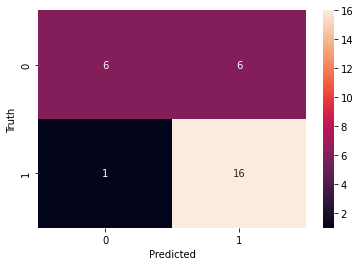

In [132]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_predicted)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [133]:
print(classification_report(y_test,y_predicted))


              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.73      0.94      0.82        17

    accuracy                           0.76        29
   macro avg       0.79      0.72      0.73        29
weighted avg       0.78      0.76      0.74        29

